# Bitcoin USD Prediction

In [1]:
#import all requried libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load bitcon price data for 2014-09-17 to 2022-07-03
data = pd.read_csv('BTC-USD.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


# Information

In [3]:
#info of datatypes and dimensions
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2847 entries, 0 to 2846
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2847 non-null   object 
 1   Open       2847 non-null   float64
 2   High       2847 non-null   float64
 3   Low        2847 non-null   float64
 4   Close      2847 non-null   float64
 5   Adj Close  2847 non-null   float64
 6   Volume     2847 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 155.8+ KB


In [4]:
#missing values
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
#basic statistics of the dataset
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2847.000000,2847.000000,2847.000000,2847.000000,2847.000000,2.847000e+03
mean,12424.499840,12747.549097,12061.046950,12429.378825,12429.378825,1.541473e+10
std,16592.544651,17020.981874,16094.974801,16587.755320,16587.755320,1.992591e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,631.980499,641.310974,623.380005,634.510010,634.510010,8.621345e+07
50%,6551.520020,6653.299805,6450.040039,6556.100098,6556.100098,5.804840e+09
75%,11498.750000,11797.744629,11240.184570,11501.107422,11501.107422,2.625695e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


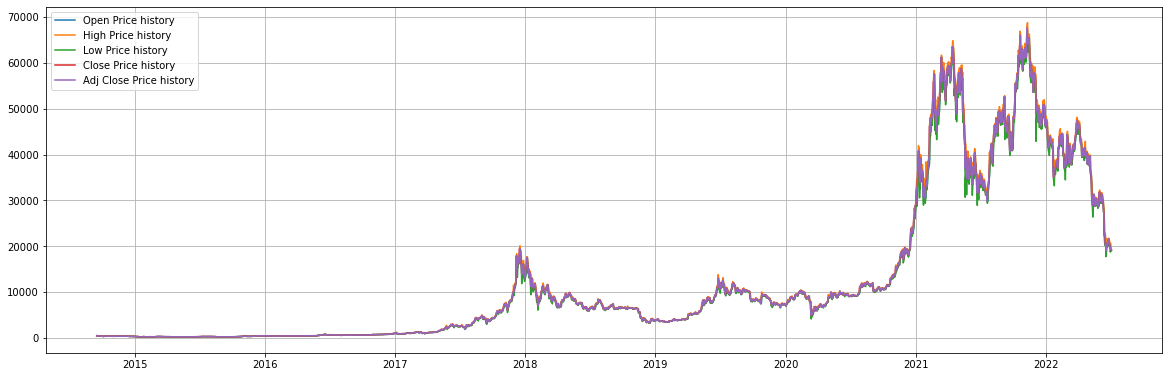

In [6]:
#TIme series visulization for all Prices.
data['Date'] = pd.to_datetime(data.Date,format="%Y-%m-%d")

data.index=data['Date']

plt.figure(figsize=(20,14))
plt.subplot(2,1,1)
plt.plot(data["Open"],label='Open Price history')
plt.plot(data["High"],label='High Price history')
plt.plot(data["Low"],label='Low Price history')
plt.plot(data["Close"],label='Close Price history')
plt.plot(data["Adj Close"],label='Adj Close Price history')
plt.grid()
plt.legend()
plt.show()

In [7]:
#Data Preprocessing
#Min Max scaling for all close price (rescale between 0 to 1)
#Prepared train test split by 2000 days data as training dataset and remaining 847 as testing dataset (total 2847 days data)

from sklearn.preprocessing import MinMaxScaler

#Sort data by date
data1=data.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(data)),columns=['Date','Close'])
L=len(data)

for i in range(0,len(data1)):
    new_dataset["Date"][i]=data1['Date'][i]
    new_dataset["Close"][i]=data1["Close"][i]
    
#Normalize the Dataset
scaler=MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
scaled_data=new_dataset.values
train_data, test_data = scaled_data[0:2000], scaled_data[2000:]

scaled_data=scaler.fit_transform(scaled_data.reshape(-1,1))

x_train_data,y_train_data=[],[]

for i in range(847 ,len(train_data)):
    x_train_data.append(scaled_data[i-847 :i,0])
    y_train_data.append(scaled_data[i,0])

In [8]:
price_series = new_dataset.reset_index().Close.values

scaler= MinMaxScaler(feature_range = (0, 1))
price_series_scaled = scaler.fit_transform(price_series.reshape(-1,1))
price_series_scaled, price_series_scaled.shape


(array([[0.00414359],
        [0.00365546],
        [0.00321557],
        ...,
        [0.28330057],
        [0.28289826],
        [0.28073865]]),
 (2847, 1))

In [9]:
#train test split by 2000 days and 847 days 
train_data, test_data = price_series_scaled[0:2000], price_series_scaled[2000:]

In [10]:
def windowed_dataset(series, time_step):
    dataX, dataY = [], []
    for i in range(len(series)- time_step-1):
        a = series[i : (i+time_step), 0]
        dataX.append(a)
        dataY.append(series[i+ time_step, 0])
        
    return np.array(dataX), np.array(dataY)

In [11]:
#mearge data with timestep data
X_train, y_train = windowed_dataset(train_data, time_step=50)
X_test, y_test = windowed_dataset(test_data, time_step=50)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((1949, 50), (1949,), (796, 50), (796,))

In [12]:
#reshape inputs to be [samples, timesteps, features] which is requred for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


print(X_train.shape) 
print(X_test.shape)

(1949, 50, 1)
(796, 50, 1)


In [13]:
#prepare RNN network LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM


model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, batch_size = 1, epochs = 1,verbose=1)

Metal device set to: Apple M1


2022-07-30 16:21:58.248035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-30 16:21:58.248654: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-30 16:21:59.422842: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-30 16:22:00.338785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 16:22:00.493595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 16:22:01.493959: I tensorflow/core/grappler/o

1949/1949 [==============================] - 49s 23ms/step - loss: 1.5676e-04


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [15]:
#evalution matrics
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error,mean_squared_error
from sklearn.metrics import r2_score

predictions = model.predict(X_test)
#predictions1 =scaler.inverse_transform(predictions)
#predictions1
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Mean squared Error - mse : " + str(mean_squared_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(np.sqrt(mean_squared_error(y_test, predictions))))
LR_MAPE= mean_absolute_percentage_error(y_test, predictions)
print("R2 square : " + str(r2_score(y_test, predictions))) 


2022-07-30 16:22:49.057489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 16:22:49.120112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/25 [>.............................] - ETA: 35s

2022-07-30 16:22:50.056844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 2s 16ms/step
Mean Absolute Error - MAE : 0.045089028886694256
Mean squared Error - mse : 0.0037892193669248845
Root Mean squared Error - RMSE : 0.06155663544188299
R2 square : 0.9406990784021536


In [16]:
#inverse scale for converting predicted data into orignal scale
predictions1 =scaler.inverse_transform(predictions)
len(predictions)

796

In [17]:
train_data=new_dataset[:L-796]
test_data=new_dataset[L-796:]
test_data['Predictions']=predictions1
test_data.head()


,Close,Predictions
Date,,
2020-04-29,8801.038086,7958.234375
2020-04-30,8658.553711,8061.288574
2020-05-01,8864.766602,8316.934570
2020-05-02,8988.59668,8578.599609
2020-05-03,8897.46875,8833.682617


In [18]:
print("Starting Date for Training Dataset",np.min(train_data.index))
print("Ending  Date for Training Dataset",np.max(train_data.index))
print("  ")
print("Starting Date for Testing Dataset",np.min(test_data.index))
print("Ending  Date for Testing Dataset",np.max(test_data.index))

Starting Date for Training Dataset 2014-09-17 00:00:00
Ending  Date for Training Dataset 2020-04-28 00:00:00
  
Starting Date for Testing Dataset 2020-04-29 00:00:00
Ending  Date for Testing Dataset 2022-07-03 00:00:00


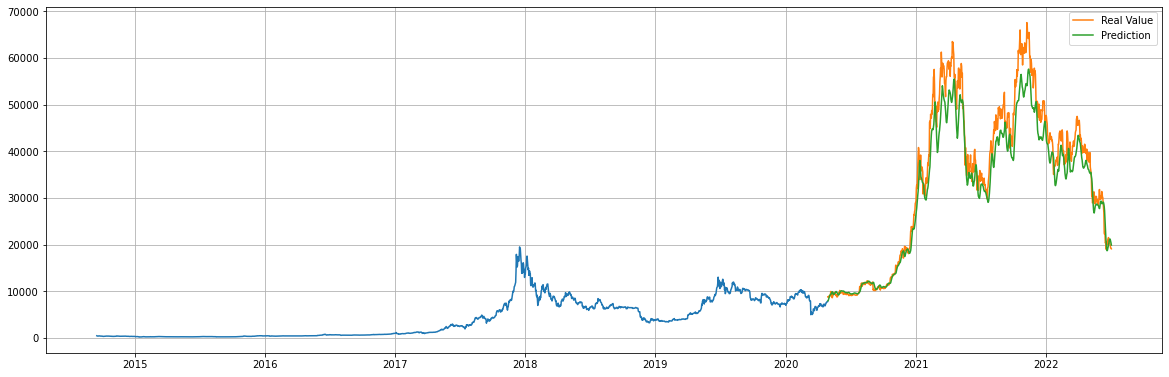

In [19]:
#plot the real values and predicted values
date_train = pd.to_datetime(train_data.index,format="%Y-%m-%d")
train_data.index=date_train

date_test = pd.to_datetime(test_data.index,format="%Y-%m-%d")
test_data.index=date_test



plt.figure(figsize=(20,14))
plt.subplot(2,1,1)
plt.plot(train_data["Close"])
plt.plot(test_data['Close'],label = "Real Value")
plt.plot(test_data["Predictions"],label = "Prediction")

plt.grid()
plt.legend()
plt.show()